In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle


from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
# from tensorflow.keras.layers.core import *
# from tensorflow.keras.layers.convolutional import *
from tensorflow.keras import backend as K
import tensorflow.compat.v1 as tf



# Initialize the setting

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [17]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 21 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.coarse = 25 # the number of classes
        self.feat_d = 210 # n(n-1)/2
        self.filters = 32
        self.data_dir = '..\\data\\JESTER\\'
C = Config()

# Building the model

In [18]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H,W],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l,joint_n,joint_d):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,joint_n*joint_d))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),joint_n*joint_d))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l,joint_n,joint_d)

    print("slow", diff_slow)
    print("fast", diff_fast)
    print("JCD", M)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    # 测试删去x_d_fast
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast]) # x = concatenate([x,x_d_slow,x_d_fast])
    print('concat', x.shape)
    x = block(x,filters*2)
    print('conv1', x.shape)
    x = MaxPool1D(2)(x)
    print('pool1', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    print('conv2', x.shape)
    x = MaxPool1D(2)(x)
    print('pool2', x.shape)    
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    print('conv3', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [19]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    print('pool', x.shape)    

    x = d1D(x,128)
    print('dense1', x.shape)    

    x = Dropout(0.5)(x)
    x = d1D(x,128)
    print('dense2', x.shape)    

    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    print('dense3', x.shape)    

    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [20]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.coarse,C.filters)

slow Tensor("reshape_2/Identity:0", shape=(None, 32, 42), dtype=float32)
fast Tensor("reshape_3/Identity:0", shape=(None, 16, 42), dtype=float32)
JCD Tensor("input_3:0", shape=(None, 32, 210), dtype=float32)
concat (None, 16, 96)
conv1 (None, 16, 64)
pool1 (None, 8, 64)
conv2 (None, 8, 128)
pool2 (None, 4, 128)
conv3 (None, 4, 256)
pool (None, 256)
dense1 (None, 128)
dense2 (None, 128)
dense3 (None, 25)


In [21]:
DD_Net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  [(None, 32, 210)]    0                                            
__________________________________________________________________________________________________
P (InputLayer)                  [(None, 32, 21, 2)]  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 4, 256)       444800      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 256)          0           model_2[1][0]              

## load data

In [22]:
# 切换成无空帧数据
Train = pickle.load(open(C.data_dir+"train_3d_custom.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"valid_3d_custom.pkl", "rb"))

## Without frame_sampling train

In [24]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.coarse)
    label[Train['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  0%|                                                                                          | 0/490 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 1323 into shape (21,2)

In [11]:
print(X_0.shape, X_1.shape, Y.shape)

label = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
for i in Y:
    for e in range(len(i)):
        if i[e] == 1:
            label[e+1] += 1
            break

print(label)

(490, 32, 210) (490, 32, 21, 3) (490, 25)
{1: 13, 2: 13, 3: 18, 4: 19, 5: 38, 6: 18, 7: 16, 8: 14, 9: 11, 10: 23, 11: 23, 12: 17, 13: 10, 14: 15, 15: 21, 16: 15, 17: 24, 18: 26, 19: 25, 20: 25, 21: 11, 22: 12, 23: 29, 24: 27, 25: 27}


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 85.53it/s]


In [13]:
print(X_test_0.shape, X_test_1.shape, Y_test.shape)

label_test = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
for i in Y_test:
    for e in range(len(i)):
        if i[e] == 1:
            label_test[e+1] += 1
            break

print(label_test)

(94, 32, 210) (94, 32, 21, 3) (94, 25)
{1: 4, 2: 3, 3: 5, 4: 2, 5: 6, 6: 2, 7: 5, 8: 3, 9: 2, 10: 3, 11: 6, 12: 7, 13: 3, 14: 3, 15: 1, 16: 4, 17: 6, 18: 3, 19: 5, 20: 3, 21: 5, 22: 2, 23: 2, 24: 4, 25: 5}


In [16]:
train_X_0 = np.vstack((X_0,X_test_0))
train_X_1 = np.vstack((X_1,X_test_1))
train_Y = np.vstack((Y,Y_test))

print(train_X_0.shape, train_X_1.shape, train_Y.shape)

import tensorflow.keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=400,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test),
#                      validation_split=0.1
                    )

(584, 32, 210) (584, 32, 21, 3) (584, 25)
Train on 490 samples, validate on 94 samples
Epoch 1/400
490/490 [==============================] - 12s 24ms/sample - loss: 0.9436 - accuracy: 0.7673 - val_loss: 2.9063 - val_accuracy: 0.1702
Epoch 2/400
490/490 [==============================] - 0s 584us/sample - loss: 1.0218 - accuracy: 0.7286 - val_loss: 2.8509 - val_accuracy: 0.1809
Epoch 3/400
490/490 [==============================] - 0s 592us/sample - loss: 1.0353 - accuracy: 0.7265 - val_loss: 2.8364 - val_accuracy: 0.1809
Epoch 4/400
490/490 [==============================] - 0s 613us/sample - loss: 0.9763 - accuracy: 0.7347 - val_loss: 2.8340 - val_accuracy: 0.1915
Epoch 5/400
490/490 [==============================] - 0s 605us/sample - loss: 0.9223 - accuracy: 0.7490 - val_loss: 2.8434 - val_accuracy: 0.2234
Epoch 6/400
490/490 [==============================] - 0s 574us/sample - loss: 0.8967 - accuracy: 0.7837 - val_loss: 2.8501 - val_accuracy: 0.2021
Epoch 7/400
490/490 [==========

Epoch 56/400
490/490 [==============================] - 0s 598us/sample - loss: 0.2567 - accuracy: 0.9571 - val_loss: 2.9607 - val_accuracy: 0.2128
Epoch 57/400
490/490 [==============================] - 0s 600us/sample - loss: 0.2685 - accuracy: 0.9429 - val_loss: 2.9771 - val_accuracy: 0.1915
Epoch 58/400
490/490 [==============================] - 0s 600us/sample - loss: 0.3066 - accuracy: 0.9388 - val_loss: 3.0010 - val_accuracy: 0.1809
Epoch 59/400
490/490 [==============================] - 0s 580us/sample - loss: 0.2450 - accuracy: 0.9612 - val_loss: 3.0199 - val_accuracy: 0.1915
Epoch 60/400
490/490 [==============================] - 0s 584us/sample - loss: 0.2484 - accuracy: 0.9531 - val_loss: 3.0506 - val_accuracy: 0.1915
Epoch 61/400
490/490 [==============================] - 0s 594us/sample - loss: 0.2395 - accuracy: 0.9510 - val_loss: 3.0879 - val_accuracy: 0.2128
Epoch 62/400
490/490 [==============================] - 0s 598us/sample - loss: 0.2308 - accuracy: 0.9633 - val_

KeyboardInterrupt: 

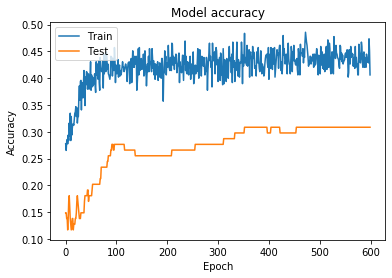

In [64]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
DD_Net.save_weights('weights/3d_9_1.h5')

In [18]:
DD_Net.load_weights('weights/3d_100.h5')

## With frame_sampling

In [30]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 

        label = np.zeros(C.coarse)
        label[Train['label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,21,2])
        p = sampling_frame(p,C)
        
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )



epoch0


100%|█████████████████████████████████████████████████████████████████████████████| 7122/7122 [00:50<00:00, 140.92it/s]


Train on 7122 samples, validate on 1604 samples


# Calculate time (excute it twice, the first time initialize takes extra times)

In [20]:
import time
start_time = time.time()
y = DD_Net.predict([X_test_0,X_test_1])
time.time() - start_time

0.10934758186340332

In [21]:
# 看一下正确情况
result = []
result_dict = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
for i in y:
#     print(i)
    max = 0
    for e in range(len(i)):
        if i[e] > i[max]:
            max = e
    result_dict[max+1] += 1
    result.append(max+1)


label = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
label_list = []
for i in Y_test:
    for e in range(len(i)):
        if i[e] == 1:
            label[e+1] += 1
            label_list.append(e+1)
            break
            
print('predcit: ',result)
print('real:    ', label_list)

print('-------------分隔符----------')
print('predict: ',result_dict)
print('real:    ',label)


clscount = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
for i in Y:
    for e in range(len(i)):
        if i[e] == 1:
            clscount[e+1] += 1
            break
print('-------------分隔符----------')
print(clscount)

predcit:  [19, 6, 17, 16, 11, 12, 6, 23, 6, 12, 24, 5, 9, 24, 7, 12, 1, 20, 24, 19, 12, 5, 21, 7, 18, 23, 17, 10, 24, 25, 20, 4, 8, 23, 8, 2, 18, 15, 25, 17, 24, 25, 16, 12, 10, 15, 20, 4, 16, 20, 17, 3, 25, 6, 23, 2, 24, 20, 2, 23, 11, 1, 3, 2, 8, 24, 1, 6, 2, 16, 15, 1, 19, 4, 2, 13, 19, 16, 4, 15, 15, 1, 13, 5, 12, 1, 18]
real:     [19, 6, 3, 16, 11, 12, 6, 23, 4, 15, 24, 24, 10, 24, 7, 12, 1, 20, 23, 20, 12, 5, 21, 11, 18, 25, 17, 10, 6, 25, 20, 4, 8, 3, 20, 13, 18, 15, 25, 15, 24, 25, 15, 8, 10, 16, 20, 4, 16, 20, 17, 3, 25, 6, 9, 2, 23, 19, 11, 15, 11, 1, 3, 12, 8, 24, 1, 16, 2, 13, 16, 1, 19, 4, 2, 14, 19, 16, 7, 16, 15, 23, 12, 5, 12, 2, 18]
-------------分隔符----------
predict:  {1: 6, 2: 6, 3: 2, 4: 4, 5: 3, 6: 5, 7: 2, 8: 3, 9: 1, 10: 2, 11: 2, 12: 6, 13: 2, 14: 0, 15: 5, 16: 5, 17: 4, 18: 3, 19: 4, 20: 5, 21: 1, 22: 0, 23: 5, 24: 7, 25: 4}
real:     {1: 4, 2: 4, 3: 4, 4: 4, 5: 2, 6: 4, 7: 2, 8: 3, 9: 1, 10: 3, 11: 4, 12: 6, 13: 2, 14: 1, 15: 6, 16: 7, 17: 2, 18: 3, 19: 4, 20:

dict_keys(['10_0', '11_0', '12_0', '1_0', '1_1', '1_2', '1_3', '1_4', '1_5', '2_0', '2_1', '2_2', '2_3', '3_0', '4_0', '5_0', '5_1', '6_0', '6_1', '7_0', '7_1', '8_0', '9_0'])
[[2.3298603e-03 1.8701674e-02 5.1615648e-03 2.6362026e-01 1.7655175e-04
  6.2869824e-02 6.9206818e-03 2.0281672e-02 2.0781910e-02 5.7913482e-01
  3.4891609e-03 1.6532054e-02]]


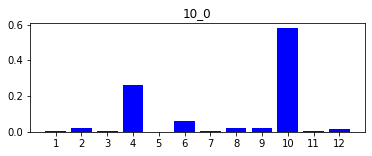

10_0 :  10
[[0.00412811 0.01095973 0.00140171 0.00995232 0.00091873 0.00161749
  0.15569259 0.3477958  0.04769531 0.2964898  0.1041175  0.0192309 ]]


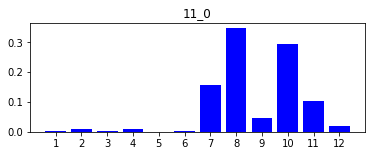

11_0 :  8
[[1.5193118e-03 9.5095197e-03 1.1391785e-04 1.6805351e-03 7.5638833e-05
  1.2718135e-03 3.4459725e-02 2.6815439e-02 1.7614629e-03 3.1429650e-03
  3.5629154e-03 9.1608673e-01]]


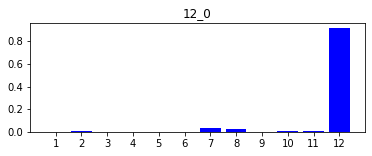

12_0 :  12
[[6.2595436e-04 8.2426943e-04 1.7444543e-03 8.9567211e-03 3.0886400e-05
  9.8647016e-01 1.0824005e-05 3.6060403e-05 1.3065989e-04 6.2210130e-04
  6.5645449e-06 5.4126547e-04]]


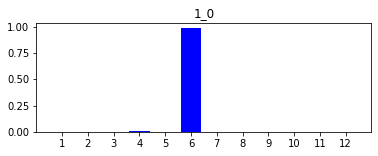

1_0 :  6
[[2.9888746e-01 2.3051308e-04 6.0979981e-04 1.2669457e-03 4.9582639e-05
  1.1566379e-04 6.7747724e-01 6.9742289e-04 3.5266080e-03 1.1886219e-02
  2.0449962e-04 5.0480426e-03]]


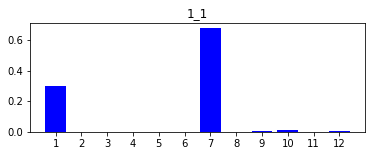

1_1 :  7
[[9.9939311e-01 1.9389967e-04 1.2676827e-04 1.5990150e-05 1.2270214e-05
  4.2920419e-06 2.4423131e-04 1.5404605e-06 1.3764699e-06 3.0682354e-06
  1.6418734e-07 3.2999303e-06]]


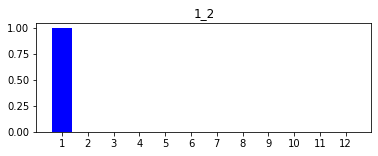

1_2 :  1
[[0.45301417 0.08911303 0.01459801 0.14747302 0.01019285 0.00469112
  0.18591128 0.03977038 0.00880284 0.03531912 0.00525732 0.00585689]]


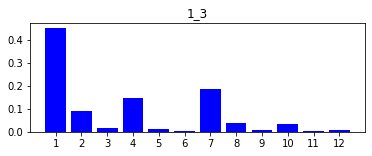

1_3 :  1
[[9.9957114e-01 7.7707591e-05 2.1862432e-04 2.9539966e-05 2.2658778e-05
  1.5152584e-05 5.6681827e-05 5.6073577e-07 1.6871855e-06 2.3416744e-06
  1.2801856e-07 3.7208902e-06]]


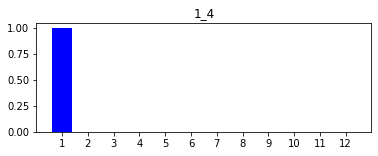

1_4 :  1
[[9.8118079e-01 5.7016360e-03 6.6928137e-03 1.7915517e-03 2.1001698e-04
  4.5102384e-04 2.7874876e-03 6.1249128e-05 2.9205222e-04 2.7938871e-04
  1.9492321e-05 5.3254550e-04]]


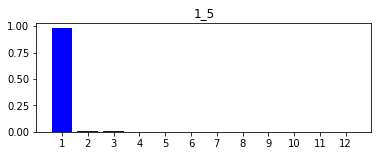

1_5 :  1
[[0.10711934 0.70433766 0.04708676 0.06252003 0.00421602 0.0176236
  0.00600921 0.01174859 0.00794271 0.00679297 0.00349906 0.02110404]]


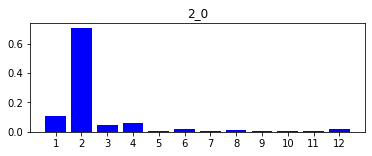

2_0 :  2
[[2.9382704e-07 9.9603015e-01 4.2204724e-06 1.0123049e-06 1.9315311e-07
  2.4419464e-06 1.9867721e-07 3.9523426e-03 1.4017476e-08 1.7680529e-07
  4.9592131e-07 8.5034444e-06]]


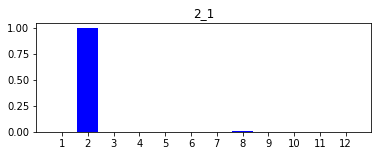

2_1 :  2
[[1.0150656e-05 9.9874496e-01 4.2062140e-05 4.7926471e-05 1.4463081e-05
  1.5892969e-05 7.9734400e-07 1.1041396e-03 2.3355803e-07 1.0482529e-06
  9.7711509e-06 8.6378905e-06]]


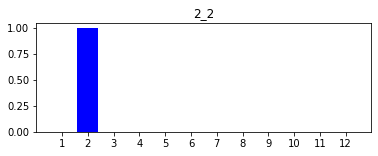

2_2 :  2
[[3.25474116e-06 9.99810398e-01 5.51345420e-06 4.61069794e-06
  1.77286415e-06 1.85618535e-06 1.03169356e-07 1.70916828e-04
  5.73032199e-09 2.73826100e-08 2.04505753e-07 1.43026057e-06]]


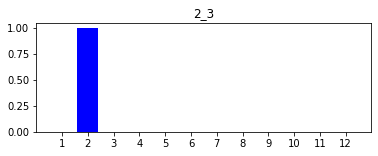

2_3 :  2
[[1.4483124e-04 4.6973565e-04 9.9203402e-01 1.7235751e-04 1.0802277e-04
  1.1685896e-03 6.5795098e-06 3.3413742e-06 5.6872885e-03 1.6308555e-04
  2.3143666e-05 1.9065386e-05]]


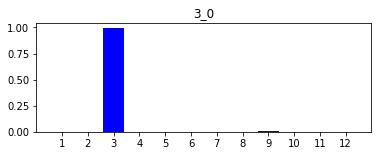

3_0 :  3
[[7.9437974e-04 4.2032643e-04 3.7176427e-02 9.1172862e-01 2.2724355e-04
  4.4023260e-02 2.2828128e-05 3.7089892e-06 4.3195981e-04 5.1280255e-03
  6.4967589e-06 3.6771278e-05]]


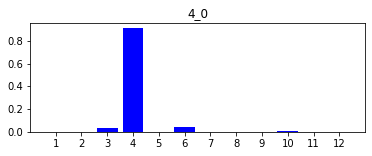

4_0 :  4
[[1.8570805e-04 2.0944601e-05 4.3843107e-04 3.6697798e-05 9.9914062e-01
  1.0758324e-06 3.2827231e-06 2.0243353e-06 8.2452761e-06 5.6223951e-07
  1.6225479e-04 1.1955048e-07]]


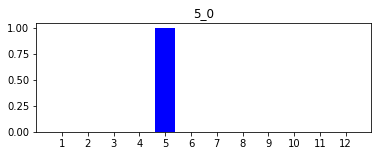

5_0 :  5
[[0.01119824 0.00344093 0.00541336 0.06095408 0.74808544 0.002505
  0.00223794 0.00183239 0.02318705 0.00452374 0.13536046 0.00126143]]


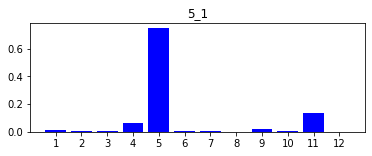

5_1 :  5
[[2.6946305e-04 5.3494616e-04 6.5990852e-04 1.2275182e-02 4.3346614e-04
  9.8314238e-01 7.5705434e-06 2.0693942e-05 2.6754540e-04 1.3127559e-04
  3.1464526e-05 2.2260130e-03]]


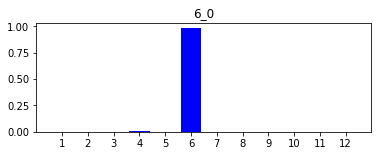

6_0 :  6
[[2.7292379e-04 5.8225909e-04 1.8582733e-04 3.9622947e-03 5.7470628e-05
  9.8830622e-01 6.6362204e-06 1.7936294e-05 2.3270391e-04 1.4257949e-04
  2.8112565e-05 6.2050205e-03]]


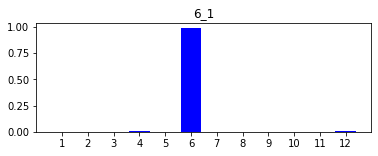

6_1 :  6
[[4.6929377e-03 9.3148788e-03 3.1780466e-04 2.8668072e-03 1.9755242e-04
  7.6243188e-04 4.1099948e-01 1.4426214e-01 8.6580589e-03 2.0461405e-02
  1.2369262e-02 3.8509724e-01]]


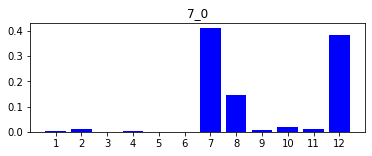

7_0 :  7
[[2.9931008e-04 4.0772560e-04 4.0543731e-04 1.6216449e-03 2.4801030e-04
  2.1516522e-03 2.9690888e-02 2.4193183e-02 1.6502535e-01 5.9452355e-01
  1.7852540e-01 2.9078873e-03]]


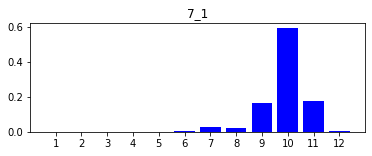

7_1 :  10
[[0.00349803 0.01374562 0.00086718 0.00693768 0.00168612 0.00345292
  0.12005226 0.44708416 0.03562732 0.14615953 0.1718262  0.04906301]]


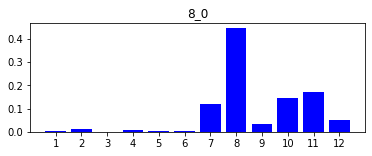

8_0 :  8
[[0.03241395 0.08181816 0.6103559  0.11726043 0.00895756 0.07378326
  0.00138057 0.00367682 0.03551251 0.02773709 0.00299961 0.00410414]]


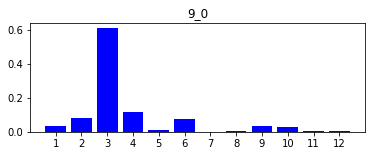

9_0 :  3


In [32]:
# 用自己的数据实验

import matplotlib.pyplot as plt

self_skel_list = pickle.load(open("C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\myskel.pkl", "rb"))
print(self_skel_list.keys())

for key in list(self_skel_list.keys()):
    skel = self_skel_list[key]
    
    p = np.copy(skel)
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    M = get_CG(p,C)

    X_My_0 = []
    X_My_0.append(p)
    X_My_0 = np.stack(X_My_0)

    X_My_1 = []
    X_My_1.append(M)
    X_My_1 = np.stack(X_My_1)

    y = DD_Net.predict([X_My_1,X_My_0])
    print(y)
    max = 0
    for i in range(len(y[0])):
        if y[0][i] > y[0][max]:
            max = i
            
    plt.figure(figsize=(6, 2))
    x=range(1,len(y[0])+1)

    plt.bar(x,y[0],color='blue')
    plt.xticks(x, x)
    plt.title(key)
    plt.show()
    print(key,': ',max+1)

# X_0 = []
# X_1 = []
# Y = []
# for i in tqdm(range(len(Train['pose']))): 
#     p = np.copy(Train['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
#     p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
#     p = normlize_range_2d(p)
    
#     label = np.zeros(C.coarse)
#     label[Train['label'][i]-1] = 1   

#     M = get_CG(p,C)

#     X_0.append(M)
#     X_1.append(p)
#     Y.append(label)

# X_0 = np.stack(X_0)  
# X_1 = np.stack(X_1) 
# Y = np.stack(Y)

##### Plot confusion matrix

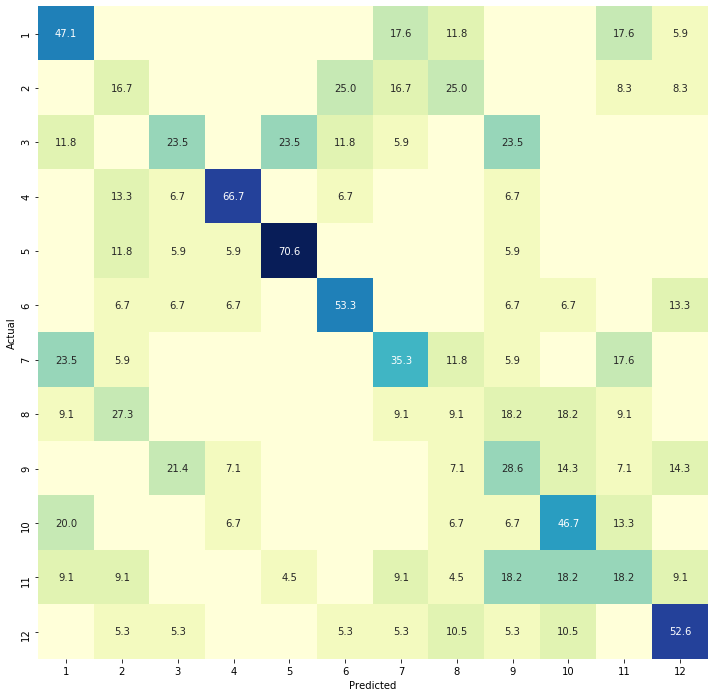

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = range(1,C.coarse+1)

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

cm_analysis(y_true,y_pred, '23.png', labels, ymap=None, figsize=(12,12))